In [22]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import math
import random
from engine import *

In [23]:
from graphviz import Digraph

def trace(root):
    #builds a set of all nodes and edges in the computational graph
    nodes ,edges = set() , set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child,v))
                build(child)
    build(root)
    return nodes, edges            


def draw_dot(root):
    dot = Digraph(format='svg' , graph_attr={'rankdir':'LR'})

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label = "{  %s |data %.4f | grad %.4f }" % (n.label,n.data, n.grad) , shape='record')
        if n.op:
            dot.node(name =uid +n.op , label = n.op)
            dot.edge(uid +n.op , uid)

    for n1 , n2 in edges:
        dot.edge(str(id(n1)),str(id(n2)) +n2.op)

    return dot

#draw_dot(root) gives out the root value 
            

In [24]:
#inputs 
x1 = Value(2.0 , label='x1')
x2 = Value(0.0 , label='x2')
w1 = Value(-3.0 , label='w1')
w2 = Value(1.0 , label='w2')
b = Value(6.8813735870195432 , label='b')  #bias weight to get desired output 0.5
x1w1 = x1 * w1 ; x1w1.label='x1w1'
x2w2 = x2 * w2 ; x2w2.label='x2w2'
x1w1x2w2 = x1w1 + x2w2 ; x1w1x2w2.label='x1w1x2w2'
n = x1w1x2w2 +b ; n.label = 'n'
o = n.tanh() ; o.label='o'
o.backward()



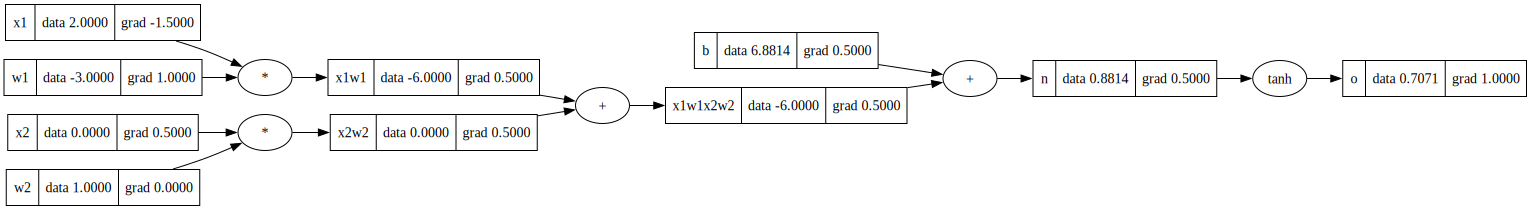

In [25]:
draw_dot(o)

In [26]:
#using o.backward() to do backpropagation without the _backward calls
'''o.backward()'''

'''#now instead of manually calling the backward methods, we can do it using the chain rule

topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)
topo             

for node in reversed(topo):
    node._backward()'''

#using the backwards method to do backpropagation
#o.grad = 1.0
'''
o._backward()
n._backward()
x1w1x2w2._backward()
b._backward()
x1w1._backward()
x2w2._backward()
'''
#this was without using the backwards method

'''o.grad= 1.0
n.grad = 0.5
x1w1x2w2.grad = 0.5
b.grad = 0.5
x1w1.grad = 0.5
x2w2.grad = 0.5

x2.grad = w2.data * x2w2.grad
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad
w2.grad = x2.data * x2w2.grad '''

'o.grad= 1.0\nn.grad = 0.5\nx1w1x2w2.grad = 0.5\nb.grad = 0.5\nx1w1.grad = 0.5\nx2w2.grad = 0.5\n\nx2.grad = w2.data * x2w2.grad\nx1.grad = w1.data * x1w1.grad\nw1.grad = x1.data * x1w1.grad\nw2.grad = x2.data * x2w2.grad '

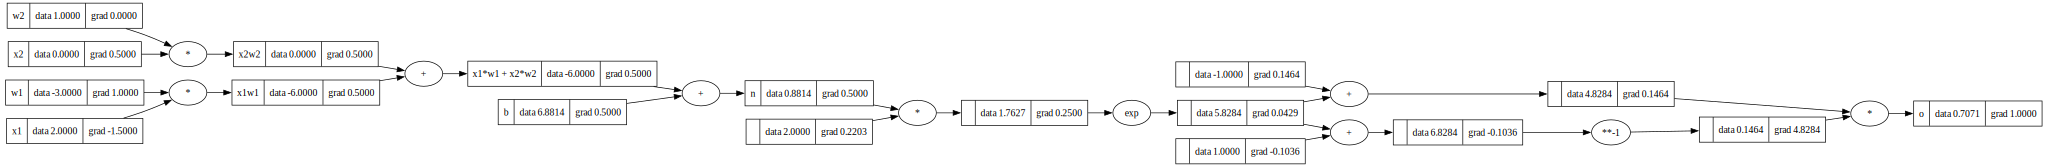

In [27]:
x1 = Value(2.0 , label='x1')
x2 = Value(0.0 , label='x2')
w1 = Value(-3.0 , label='w1')
w2 = Value(1.0 , label='w2')
b = Value(6.8813735870195432 , label='b')  #bias weight to get desired output 0.5
x1w1 = x1 * w1 ; x1w1.label='x1w1'
x2w2 = x2 * w2 ; x2w2.label='x2w2'
x1w1x2w2 = x1w1 + x2w2 ; x1w1x2w2.label='x1*w1 + x2*w2'
n = x1w1x2w2 +b ; n.label = 'n'

#--- IGNORE ---

e = (2*n).exp()
o = (e-1)/(e+1)
#--- IGNORE ---
o.label = 'o'
o.backward()
draw_dot(o)


In [28]:
#doing the same stuff in pytorch now directly 
import torch

In [29]:

#as all of theme are leafnodes pytorch assume they dont need grad unless we specify requires_grad = True
x1 = torch.Tensor([2.0]).double()   ;x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()   ;x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()  ;w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()   ;w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ;b.requires_grad = True #bias weight to get desired output 0.5
# --- IGNORE ---
n = w1*x1 + w2*x2 +b

o =torch.tanh(n)

print(o.data.item())
o.backward()

print('___')
print('x1',x1.grad.item())
print('x2',x2.grad.item())
print('w1',w1.grad.item())
print('w1',w2.grad.item())

0.7071066904050358
___
x1 -1.5000003851533106
x2 0.5000001283844369
w1 1.0000002567688737
w1 0.0


In [30]:
torch.Tensor([2.0]).double().dtype

torch.float64

In [31]:
#building simple neuron
#nin = number of inputs how many inputs come to neuron

class Neuron():

    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self ,x):
        activation = sum( (wi*xi for wi ,xi in zip(self.w , x)) , self.b)
        output = activation.tanh()
        return output

    def parameters(self):
        return self.w + [self.b]
    

#making a layer of neurons takein nin and nout(number of outputs) from previous cells

class Layer():
    def __init__(self , nin , nout):
        self.neurons = [ Neuron(nin) for _ in range(nout)]

    def __call__(self , x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) ==1 else outs 
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]


#making a multi layer perceptron taking nin and nouts(list of number of outputs for each layer)

class MLP():
    def __init__(self , nin , nouts):
        sz = [nin] + nouts
        self.layers = [ Layer(sz[i] , sz[i+1]) for i in range(len(nouts))]

    def __call__(self , x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]


In [32]:
x = [2.0,3.0 , -1.0]
n =MLP(3 ,[16,16,1])

print(n(x))
n(x).backward()
#draw_dot(n(x))


Value(data=-0.8885730721126016)


In [33]:
n.parameters()

[Value(data=0.4958697213321015),
 Value(data=-0.1516800496238011),
 Value(data=-0.10059233095187814),
 Value(data=0.07559673597392802),
 Value(data=-0.7038143134142412),
 Value(data=-0.028713834049237885),
 Value(data=0.25125528839018596),
 Value(data=0.6168622859801385),
 Value(data=-0.2896153696346573),
 Value(data=-0.0931238748897818),
 Value(data=0.7154589550842554),
 Value(data=-0.09280426140924014),
 Value(data=0.8575058370859325),
 Value(data=0.13935054505514288),
 Value(data=-0.22416290052933951),
 Value(data=-0.5823848334940185),
 Value(data=-0.8627821092110963),
 Value(data=0.8479907686927837),
 Value(data=0.10720617326039128),
 Value(data=-0.7745028293441694),
 Value(data=-0.22447498929507526),
 Value(data=-0.23268192524013576),
 Value(data=0.9031871922937909),
 Value(data=0.4173892484673931),
 Value(data=0.8585725601609919),
 Value(data=0.7335559507135767),
 Value(data=-0.06074808889200223),
 Value(data=-0.645572419770799),
 Value(data=-0.7880057798010551),
 Value(data=-0.0

In [34]:
len(n.parameters())
n(x).backward()

In [35]:
#simply trying to make binary classifier neural net

#the dataset


xs = [
    [2.0 , 3.0 , -1.0],
    [3.0 , -1.0 , 0.5],
    [0.5 , 1.0 , 1.0 ],
    [1.0 , 1.0 , -1.0]]

ys = [1.0 ,  -1.0 , -1.0 , 1.0] #the desired outputs



In [36]:
#forward pass
#defining loss which tells well how bad our predictions are
for k in range(100):
    ypred = [n(x) for x in xs]
    loss = sum([(yout-ygt)**2 for ygt , yout in zip(ys , ypred)])
    #backward pass

    for p in n.parameters():
        p.grad = 0.0

    loss.backward()

    #apllying the gradient descent step
    #updating each parameter according to its gradient

    for p in n.parameters():
        p.data += -0.01 * p.grad 

    print(k , loss.data)     


0 12.809957567233871
1 8.578906753230726
2 5.177929308462064
3 3.5375374776467816
4 2.3035117620010492
5 1.0442357636845954
6 0.5894377188917832
7 0.42264971657870665
8 0.3334215770290323
9 0.27672475587307876
10 0.23707024724596668
11 0.20759914164436
12 0.18475740910879046
13 0.1664981690708247
14 0.1515502663969907
15 0.13907855012010023
16 0.1285098110741426
17 0.11943662465537644
18 0.1115609790934438
19 0.1046596013833193
20 0.09856176647836397
21 0.09313461426211853
22 0.08827315401751623
23 0.08389329067856366
24 0.07992685376188186
25 0.07631798611892898
26 0.07302047597338913
27 0.06999575588172872
28 0.067211381344169
29 0.0646398597359338
30 0.062257738702480483
31 0.06004488919163087
32 0.057983936207425604
33 0.05605980288939301
34 0.05425934239599543
35 0.05257103844589223
36 0.05098476000547097
37 0.049491559018866815
38 0.04808350260857084
39 0.04675353307425612
40 0.04549535045559724
41 0.0443033135230141
42 0.043172355905568255
43 0.042097914720814575
44 0.0410758695

In [37]:
ypred

[Value(data=0.9396217570071346),
 Value(data=-0.9184464012886837),
 Value(data=-0.9361038931508463),
 Value(data=0.9425956064676908)]

In [39]:
#draw_dot(loss)